In [1]:
#Import modules
import textacy
import spacy
import scattertext as st
import pandas as pd
from pathlib import Path
from plotnine import *

#change language to german
de = textacy.load_spacy_lang("de_core_news_sm")

In [2]:
#make Python understand gender
m = "male"
f = "female"
Geschlecht = [m,f]

In [3]:
#read dataset (male) from csv file
f_csv = '../KED2022/materials/data/dataset_speeches_m.csv'
df = pd.read_csv(f_csv)

# filter out non-german texts or very short texts
df_sub = df[(df['Sprache'] == 'de') & (df['text'].str.len() > 10)]

# make new column containing all relevant metadata (showing in plot later on)
df_sub['descripton'] = df_sub[['Redner', 'Partei', 'Jahr']].astype(str).agg(', '.join, axis=1)

# sneak peek of dataset
df_sub.head()

,Jahr,Status,Vollständigkeit,Redner,Geschlecht,Funktion,Partei,Partei-Original,Typ,Bemerkung,Sprache,Originalsprache,Ort,Titel,Anrede,Originaltext,Quelle,text,descripton
0,2018,done,vollständig,Alain Berset,m,BP,SP,SP,BP-Rede,NaN,de,NaN,NaN,NaN,Sehr geehrte Damen und Herren,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,Wir leben in der Schweiz in Frieden und Wohlst...,"Alain Berset, SP, 2018"
3,2018,done,vollständig,Guy Parmelin,m,BR,SVP,SVP,Lokal,NaN,de,NaN,NaN,«Armbrust und Hellebarde»,"Sehr geehrte Eidgenossen, Meine Damen und Herren",NaN,https://www.admin.ch/gov/de/start/dokumentatio...,Eine 1.-August-Rede ist eine der heikelsten rh...,"Guy Parmelin, SVP, 2018"
4,2018,done,vollständig,Ignazio Cassis,m,BR,FDP,FDP,Lokal,NaN,de,NaN,Rorschach,Die Italianità hat ihre Wurzeln in Rorschach,Gueten Obig mitenand!,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,Und danke für diese freundliche Einladung! Ich...,"Ignazio Cassis, FDP, 2018"
6,2017,done,vollständig,Didier Burkhalter,m,BR,FDP,FDP,Lokal,NaN,de,fr,Aigle-Les Diablerets,„Le 1er août est un voyage à travers la Suisse...,"Mesdames et Messieurs, et chers amis,",Le 1er août est un voyage. Et pour mon épouse ...,https://www.admin.ch/gov/de/start/dokumentatio...,Der 1. August ist eine Reise. Und für meine Fr...,"Didier Burkhalter, FDP, 2017"
7,2017,done,vollständig,Guy Parmelin,m,BR,SVP,SVP,Lokal,NaN,de,NaN,Bern,"«Ein Land, das stolz auf seine Traditionen ist...",Sehr geehrte Eidgenossen\nMeine Damen und Herren,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,Für uns ist der 1. August mehr als ein Nationa...,"Guy Parmelin, SVP, 2017"


In [4]:
#create corpus for male dataset
def get_texts_from_csv(f_csv, text_column):
    """
    Read dataset from a csv file and sequentially stream the rows,
    including metadata.
    """
    
    # read dataframe
    df = pd.read_csv(f_csv)
    
    # keep only documents that have text
    filtered_df = df[df[text_column].notnull()]
    
    # iterate over rows in dataframe
    for idx, row in filtered_df.iterrows():
        
        # read text and join lines (remove hard line-breaks)
        text = row[text_column].replace('\n', ' ')

        # use all columns as metadata, except the column with the actual text
        metadata = row.to_dict()
        del metadata[text_column]

        yield (text, metadata)

f_csv = '../KED2022/materials/data/dataset_speeches_m.csv'
texts = get_texts_from_csv(f_csv, text_column='text')

corpus_speeches_m = textacy.Corpus(de, data=texts)

In [5]:
# define what groups are formed and what terms should be included
# here, groups by year and words are lowercased (incl. stop words)
tokenized_docs, groups = textacy.io.unzip(
        (textacy.extract.utils.terms_to_strings(textacy.extract.words(doc, filter_stops=False), by="lower"),
        doc._.meta["Jahr"])
        for doc in corpus_speeches_m)

# define how to count
# here relative term frequency
vectorizer = textacy.representations.vectorizers.GroupVectorizer(
        tf_type='linear', # absolute term frequency
        dl_type="linear", # normalized by document length
        vocabulary_grps=range(1950, 2019)) # limit to years from 1950 to 2019

# create group-term-matrix with with frequency counts
grp_term_matrix = vectorizer.fit_transform(tokenized_docs, groups)

# create dataframe from matrix
df_terms = pd.DataFrame.sparse.from_spmatrix(grp_term_matrix, index=vectorizer.grps_list, columns=vectorizer.terms_list)
df_terms['year'] = df_terms.index

# change shape of dataframe
df_tidy = df_terms.melt(id_vars='year', var_name="term", value_name="frequency")
df_tidy

/home/nilsos/.local/lib/python3.8/site-packages/textacy/representations/vectorizers.py:673: RuntimeWarning: divide by zero encountered in true_divide


,year,term,frequency
0,1950,'s,0.0
1,1951,'s,0.0
2,1952,'s,0.0
3,1953,'s,0.0
4,1954,'s,0.0
...,...,...,...
1119175,2014,−,0.0
1119176,2015,−,0.0
1119177,2016,−,0.0
1119178,2017,−,0.0


/home/nilsos/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 250 rows containing missing values.


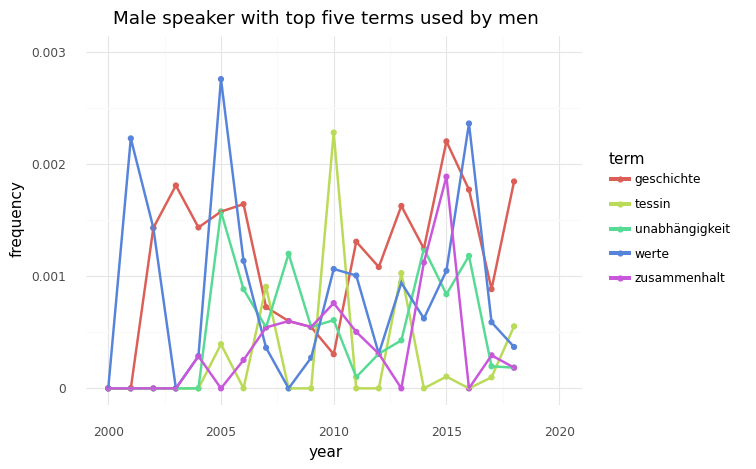

<ggplot: (8747025210257)>

In [6]:
# filter the dataset for the five most used terms in speeches read by a female speaker
terms = ["geschichte", "zusammenhalt", "tessin", "unabhängigkeit", "werte"]
df_terms = df_tidy[df_tidy['term'].isin(terms)]

# plot the relative frequency for the terms above
(ggplot(df_terms, aes(x='year', y='frequency', color='term'))
 + ggtitle('Male speaker with top five terms used by men') # give plot a name to differentiate from male plot
 + geom_point() # show individual points
 + stat_smooth(method='lowess', span=0.15, se=False) # overlay points with a smoothed line
 + ylim(0,0.003)
 + xlim(2000,2020) # change x-axis numbers to match the data
 + theme_minimal()) # make the plot look nicer

/home/nilsos/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 250 rows containing missing values.


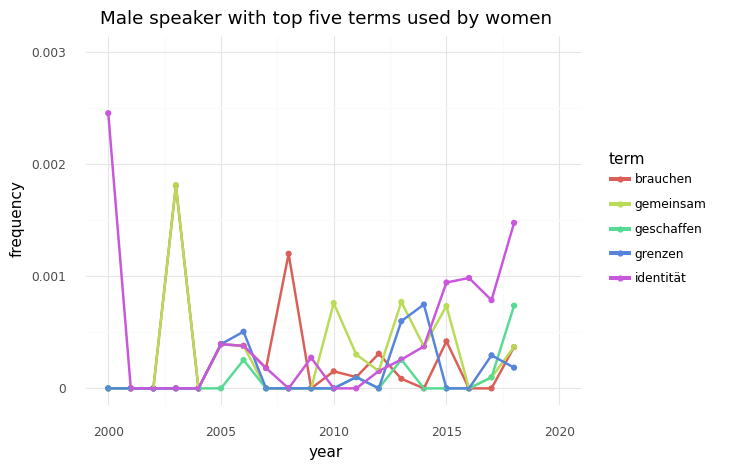

<ggplot: (8747020953965)>

In [7]:
# filter the dataset for the five most used terms in speeches read by a female speaker
terms = ["gemeinsam", "grenzen", "brauchen", "geschaffen", "identität"]
df_terms = df_tidy[df_tidy['term'].isin(terms)]

# plot the relative frequency for the terms above
(ggplot(df_terms, aes(x='year', y='frequency', color='term'))
 + ggtitle('Male speaker with top five terms used by women') # give plot a name to differentiate from male plot
 + geom_point() # show individual points
 + stat_smooth(method='lowess', span=0.15, se=False) # overlay points with a smoothed line
 + ylim(0,0.003)
 + xlim(2000,2020) # change x-axis numbers to match the data
 + theme_minimal()) # make the plot look nicer